In [1]:
import os
import cv2
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from torch.utils.data import DataLoader

from utils.utils import Args
from data.util import mask_encoding, mask_decoding, get_bbox_from_mask
from data.augmentation import basic_transform, mosaic, sep, apply_transform, get_bg_image, mixup

# 데이터 경로

In [2]:
data_path = "/home/pervinco/Datasets/BKAI-IGH-NeoPolyp"

image_dir = f"{data_path}/train/train"
mask_dir = f"{data_path}/train_gt/train_gt"

image_files = sorted(glob(f"{image_dir}/*.jpeg"))
mask_files = sorted(glob(f"{mask_dir}/*.jpeg"))

print(len(image_files), len(mask_files))

1000 1000


In [3]:
idx = 3
image_file = image_files[idx]
mask_file = mask_files[idx]
print(image_file, mask_file)

image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_file)

/home/pervinco/Datasets/BKAI-IGH-NeoPolyp/train/train/00fd197cd955fa095f978455cef3593c.jpeg /home/pervinco/Datasets/BKAI-IGH-NeoPolyp/train_gt/train_gt/00fd197cd955fa095f978455cef3593c.jpeg


# 마스크 인코딩 & 디코딩

(977, 1280)
[0 2]


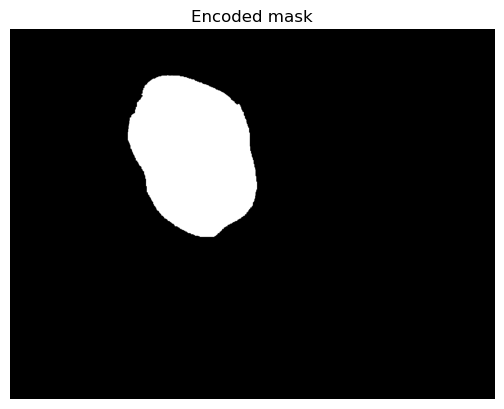

In [4]:
encoded_mask = mask_encoding(mask)
print(encoded_mask.shape)
print(np.unique(encoded_mask))

plt.imshow(encoded_mask, cmap="gray")
plt.title("Encoded mask")
plt.axis('off')
plt.show()

(977, 1280, 3)
[  0 255]


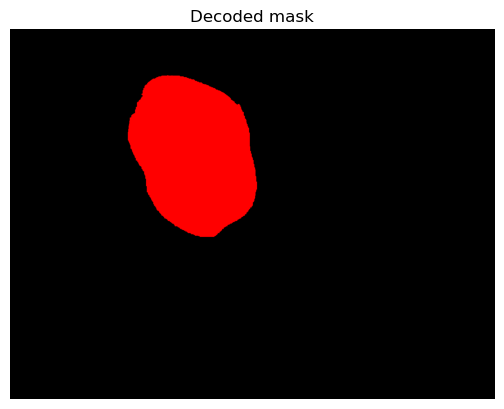

In [5]:
decoded_mask = mask_decoding(encoded_mask)
print(decoded_mask.shape)
print(np.unique(decoded_mask))

plt.imshow(decoded_mask)
plt.title("Decoded mask")
plt.axis('off')
plt.show()

In [6]:
save_dir = f"{data_path}/train_masks"
os.makedirs(f"{save_dir}/red", exist_ok=True)
os.makedirs(f"{save_dir}/green", exist_ok=True)
os.makedirs(f"{save_dir}/rng", exist_ok=True)
os.makedirs(f"{data_path}/train_mask", exist_ok=True)

red_masks = []
green_masks = []
red_and_green_masks = []
for mask_file in mask_files:
    tag = None
    file_name = mask_file.split('/')[-1].split('.')[0]
    mask = cv2.imread(mask_file)
    encoded_mask = mask_encoding(mask)
    classes = np.unique(encoded_mask)
    
    if 1 not in classes:
        tag = "red"
        red_masks.append(file_name)
    elif 2 not in classes:
        tag = "green"
        green_masks.append(file_name)
    else:
        tag = "rng"
        red_and_green_masks.append(file_name)

    decoded_mask = mask_decoding(encoded_mask)
    decoded_mask = cv2.cvtColor(decoded_mask, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"{save_dir}/{tag}/{file_name}.jpeg", cv2.resize(decoded_mask, (512, 512)))
    cv2.imwrite(f"{data_path}/train_mask/{file_name}.jpeg", decoded_mask)

print(len(red_masks), len(green_masks), len(red_and_green_masks))

257 693 50


In [7]:
for key, value in {"reds" : red_masks, "greens" : green_masks, "red_and_greens" : red_and_green_masks}.items():
    df = pd.DataFrame({'file_name' : value})
    df.to_csv(f"{data_path}/files/{key}.csv", index=False)

# 균형 데이터셋 제작

In [8]:
random.seed(42)

## green에서 27개의 데이터는 validation으로 사용
print(len(green_masks))
random.shuffle(green_masks)
train_green_masks = green_masks[:230]
valid_green_masks = green_masks[230:]
print(len(train_green_masks), len(valid_green_masks), '\n')


## red에서 23개의 데이터를 validation으로 사용
print(len(red_masks))
random.shuffle(red_masks)
train_red_masks = red_masks[:670]
valid_red_masks = red_masks[670:]
print(len(train_red_masks), len(valid_red_masks), '\n')

## train_red_masks를 train_green_masks와 동등한 비율로 여러 개의 데이터셋으로 분할.
random.shuffle(train_red_masks)
train_red_masks1 = train_red_masks[:230]
train_red_masks2 = train_red_masks[230:460]
train_red_masks3 = train_red_masks[460:]
print(len(train_red_masks1), len(train_red_masks2), len(train_red_masks3), '\n')

## red_and_green_masks에서 10개는 validation으로 사용
print(len(red_and_green_masks))
train_rng_masks = red_and_green_masks[:40]
valid_rng_masks = red_and_green_masks[40:]
print(len(train_rng_masks), len(valid_rng_masks))

693
230 463 

257
257 0 

230 27 0 

50
40 10


In [9]:
train1 = train_red_masks1 + train_green_masks + train_rng_masks
train2 = train_red_masks2 + train_green_masks + train_rng_masks
train3 = train_red_masks3 + train_green_masks + train_rng_masks

print(len(train1), len(train2), len(train3))

for key, value in {"train1" : train1, "train2" : train2, "train3" : train3}.items():
    df = pd.DataFrame({"file_name" : value})
    df.to_csv(f"{data_path}/files/{key}.csv", index=False)

500 297 270


In [10]:
valid = valid_red_masks + valid_green_masks + valid_rng_masks
print(len(valid))

df = pd.DataFrame({"file_name" : valid})
df.to_csv(f"{data_path}/files/valid.csv", index=False)

473


In [11]:
df = pd.read_csv(f"{data_path}/files/train1.csv")
df.head()

,file_name
0,1573af7f31f04dc06992d92472facb34
1,f3593cef221b7a23b8c34c4287d4c9ac
2,81fe4727080cae6daedd989517cb8041
3,e101f07b34db8907f74aefafdacfbed3
4,047dc0cbb58aa032554b5eb4fcf0130a


In [12]:
df.file_name.to_list()

['1573af7f31f04dc06992d92472facb34',
 'f3593cef221b7a23b8c34c4287d4c9ac',
 '81fe4727080cae6daedd989517cb8041',
 'e101f07b34db8907f74aefafdacfbed3',
 '047dc0cbb58aa032554b5eb4fcf0130a',
 '40676289b3e732adb4c5d1580670d78b',
 'c34a359bbb402345d341253851bc866e',
 '298e11bb07c70f3701ae6bcec5dd8e74',
 'bdfb928d788e4237a32841b23099dd2e',
 'c4c65193c5141a869d6643c270866fd3',
 'a39099848c4425bf33b9b001c13a3d81',
 'a59c7de13a35276a476420655433a925',
 'fccacf464aa36bf7c09a3bb0e5ca1594',
 '0b1300cb1b387133b51209db6dcdda5c',
 'fcfedb5eb2a0e4b50889d874c68c030b',
 'd24a2ac9e88b2be8379499640676289b',
 'a0ef759a3a33a0565586918cd5eb80e6',
 '424de1556a26c8eba4c1db1a0b47aa6b',
 '467e5cbc04772d9e593b6be1ac29adbe',
 '4af626650908b1cb932a767bf5487ced',
 'dbc3bbc04a3afe1f119f21b248d152b6',
 'd287a51b9298e11bb07c70f3701ae6bc',
 '00fd197cd955fa095f978455cef3593c',
 '2c41545ba55aadaa77712a48e11d579d',
 '5b1393e2ef89424de1556a26c8eba4c1',
 '76135d76d0bbd4ce2a1405f7d507592b',
 '408cc3736e216b08d237285e26c90e17',
 

In [19]:
import os
import cv2
import random
import numpy as np
import pandas as pd

from glob import glob
from torch.utils.data import Dataset

from data.util import mask_encoding
from data.augmentation import basic_transform, apply_transform, sep, mosaic, mixup, get_bg_image

class BKAIDataset(Dataset):
    CLASSES = ["background", "non-neoplastic polyps", "neoplastic polyps"]
    COLORMAP = [[0, 0, 0], [0, 255, 0], [255, 0, 0]]

    def __init__(self, args, feature_extractor=None, image_set="train", train_idx=1):
        self.args = args
        self.feature_extractor = feature_extractor
        self.is_train = True if image_set == "train" else False
        
        self.data_dir = args.data_dir
        self.image_dir = f"{self.data_dir}/train/train"
        self.mask_dir = f"{self.data_dir}/train_mask"
        self.bbox_dir = f"{self.data_dir}/train_boxes"
        self.transform = basic_transform(is_train=self.is_train, img_size=args.img_size)

        if image_set == "train":        
            total_df = pd.read_csv(f"{args.data_dir}/files/{image_set}{train_idx}.csv")
            self.total_files = total_df['file_name'].to_list()
            random.shuffle(self.total_files)
        else:
            total_df = pd.read_csv(f"{args.data_dir}/files/{image_set}.csv")
            self.total_files = total_df['file_name'].to_list()
            random.shuffle(self.total_files)
        

    def __len__(self):
        return len(self.total_files)

    def get_img_mask(self, file_name):
        file_name = file_name.split('.')[0]
        image_path = f"{self.image_dir}/{file_name}.jpeg"
        mask_path = f"{self.mask_dir}/{file_name}.jpeg"
        bbox_path = f"{self.bbox_dir}/{file_name}.txt"
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        
        labels = []
        bboxes = []
        if os.path.exists(bbox_path):
            with open(bbox_path, 'r') as f:
                for line in f:
                    label, xmin, ymin, xmax, ymax = map(int, line.strip().split())
                    labels.append(label)
                    bboxes.append((xmin, ymin, xmax, ymax))
                    
        return image, mask, bboxes, labels


    def __getitem__(self, idx):
        file_name = self.total_files[idx]
        image, mask, bboxes, labels = self.get_img_mask(file_name)
        batch_image, batch_mask, batch_bboxes, batch_labels = apply_transform(image, mask, bboxes, labels, self.transform)

        batch_mask = mask_encoding(batch_mask)
        if self.feature_extractor is not None:
            encoded_inputs = self.feature_extractor(batch_image, batch_mask, return_tensors="pt")
            for k, v in encoded_inputs.items():
                encoded_inputs[k].squeeze_()

            return encoded_inputs   
        
        else:
            return batch_image, batch_mask

In [20]:
args = Args("/home/pervinco/SemanticSegmentation/config.yaml", is_train=False)
dataset = BKAIDataset(args, image_set="train")

In [21]:
def visualize_dataset_sample(dataset, idx):
    image, encoded_mask = dataset[idx]
    
    # image = image.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # image = std * image + mean
    # image = np.clip(image, 0, 1)
    
    decoded_mask = mask_decoding(encoded_mask)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    axes[1].imshow(decoded_mask)
    axes[1].set_title('Decoded Mask')
    axes[1].axis('off')
    
    plt.show()

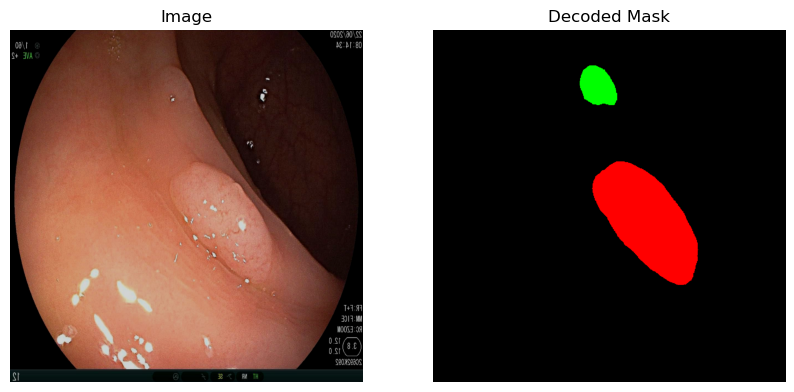

In [22]:
visualize_dataset_sample(dataset, idx=1)

In [23]:
args.num_workers = os.cpu_count()
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloader = DataLoader(dataset, batch_size=4)

In [24]:
if not os.path.exists(f"{data_path}/batch_images"):
    os.makedirs(f"{data_path}/batch_images")

for i, (images, masks) in enumerate(dataloader):
    print(images.shape, masks.shape)
    if i == 10:
        break
    images, masks = images.numpy(), masks.numpy()
    for j, (image, mask) in enumerate(zip(images, masks)):
        mask = mask_decoding(mask)

        overlay = cv2.addWeighted(image, 0.7, mask, 0.3, 0)
        result = np.hstack((image, mask, overlay))
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

        cv2.imwrite(f"{data_path}/batch_images/batch{i}_no{j}.png", result)

torch.Size([4, 960, 960, 3]) torch.Size([4, 960, 960])
torch.Size([4, 960, 960, 3]) torch.Size([4, 960, 960])
torch.Size([4, 960, 960, 3]) torch.Size([4, 960, 960])
torch.Size([4, 960, 960, 3]) torch.Size([4, 960, 960])
torch.Size([4, 960, 960, 3]) torch.Size([4, 960, 960])
torch.Size([4, 960, 960, 3]) torch.Size([4, 960, 960])
torch.Size([4, 960, 960, 3]) torch.Size([4, 960, 960])
torch.Size([4, 960, 960, 3]) torch.Size([4, 960, 960])
torch.Size([4, 960, 960, 3]) torch.Size([4, 960, 960])
torch.Size([4, 960, 960, 3]) torch.Size([4, 960, 960])
torch.Size([4, 960, 960, 3]) torch.Size([4, 960, 960])
